In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset

DTYPE = torch.float32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

# Data


In [2]:
def load_data(file_path: str) -> torch.Tensor:
    # load the data in the format timestamp, X, Y, phi, v_x, v_y, r, T, delta, dT, ddelta
    raw_data = np.loadtxt(file_path, delimiter=",", skiprows=1)
    idx = np.arange(0, raw_data.shape[0])
    # remove the first rows that are far from 0 in position
    tpr = np.argwhere(np.linalg.norm(raw_data[:, 1:3], axis=1) <= 0.1).ravel()
    idx1 = idx[tpr[0] :]
    # only keep the states where the control (T, delta) changes
    tpr = np.argwhere(
        (raw_data[:, 7] != np.roll(raw_data[:, 7], 1))
        | (raw_data[:, 8] != np.roll(raw_data[:, 8], 1))
    ).ravel()
    idx2 = idx[tpr]
    return torch.from_numpy(raw_data[np.intersect1d(idx1, idx2), :]).to(
        dtype=DTYPE, device=DEVICE
    )


class SysidDataset(Dataset):
    def __init__(
        self,
        file_paths: list[str] = ["data/fsds_competition_2_10.csv"],
        transform=None,
        return_time_stamp=False,
    ):
        self.data = torch.cat([load_data(path) for path in file_paths], dim=0)
        self.transform = transform
        self.return_time_stamp = return_time_stamp

    def __len__(self):
        return len(self.data) - 1

    def __getitem__(self, idx):
        # if idx <
        if self.return_time_stamp:
            return (
                self.data[idx, 0],
                self.data[idx, 1:-2],
                self.data[idx, -2:],
                self.data[idx + 1, 1:-2],
            )
        else:
            return self.data[idx, 1:-2], self.data[idx, -2:], self.data[idx + 1, 1:-2]


data = SysidDataset([f"data/fsds_competition_2_{v}.csv" for v in [5, 10, 15]])
train_size = int(0.8 * len(data))
validation_size = int(0.1 * len(data))
test_size = len(data) - train_size - validation_size
print("train size: ", train_size)
print("validation size: ", validation_size)
print("test size: ", test_size)

train_data, validation_data, test_data = torch.utils.data.random_split(
    data, [train_size, validation_size, test_size]
)

train_loader = DataLoader(train_data, batch_size=2904, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=363, shuffle=True)
test_loader = DataLoader(test_data, batch_size=363, shuffle=True)


train size:  2904
validation size:  363
test size:  363


# Model

In [3]:
class Net(nn.Module):
    """
    from the following input: x=(X, Y, phi, v_x, v_y, r, T, delta), u=(dT, ddelta)
    """

    def __init__(self, n_input=10, n_output=6, n_hidden=(32, 32)) -> None:
        super().__init__()
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(n_input, n_hidden[0]))
        for i in range(len(n_hidden) - 1):
            self.hidden_layers.append(nn.Linear(n_hidden[i], n_hidden[i + 1]))
        self.output_layer = nn.Linear(n_hidden[-1], n_output)

    def forward(self, x, u):
        z = torch.cat((x, u), dim=1)
        z = self.leaky_relu(self.hidden_layers[0](z))
        for i in range(1, len(self.hidden_layers)):
            z = self.leaky_relu(self.hidden_layers[i](z)) + z
        z = self.output_layer(z)
        return z

class ODE1(nn.Module):
    def __init__(self, n_hidden=(32, 32), m=255.0, l_R=0.8, l_F=0.4) -> None:
        super().__init__()
        self.net = Net(n_hidden=n_hidden, n_output=3)
        self.m = m
        self.l_R = l_R
        self.l_F = l_F

    def forward(self, x, u):
        bruh = self.net(x, u)
        X = x[:, 0]
        Y = x[:, 1]
        phi = x[:, 2]
        v_x = x[:, 3]
        v_y = x[:, 4]
        r = x[:, 5]
        T = x[:, 6]
        delta = x[:, 7]
        dT = u[:, 0]
        ddelta = u[:, 1]

        v_x_dot = bruh[:, 0]
        v_y_dot = bruh[:, 1]
        r_dot = bruh[:, 2]
        return torch.stack(
            [
                X * torch.cos(phi) - Y * torch.sin(phi),
                X * torch.sin(phi) + Y * torch.cos(phi),
                r,
                v_x_dot,
                v_y_dot,
                r_dot,
                dT,
                ddelta,
            ],
            dim=1,
        )

class ODE2(nn.Module):
    def __init__(self, n_hidden=(32, 32), m=255.0, l_R=0.8, l_F=0.4) -> None:
        super().__init__()
        self.net = Net(n_hidden=n_hidden, n_output=6)
        self.m = m
        self.l_R = l_R
        self.l_F = l_F 

        def forward(self, x, u):
            bruh = self.net(x, u)
            X = x[:, 0]
            Y = x[:, 1]
            phi = x[:, 2]
            v_x = x[:, 3]
            v_y = x[:, 4]
            r = x[:, 5]
            T = x[:, 6]
            delta = x[:, 7]
            dT = u[:, 0]
            ddelta = u[:, 1]

            F_x = bruh[:, 0]
            F_y_R = bruh[:, 1]
            F_y_F = bruh[:, 2]
            I_z = bruh[:, 3]
            v_x_1 = bruh[:, 4]
            v_x_2 = bruh[:, 5]
            lam = torch.clip((v_x - v_x_1) / (v_x_2 - v_x_1), 0, 1)
            m = self.m
            l_R = self.l_R
            l_F = self.l_F
            return torch.stack(
                [
                    X * torch.cos(phi) - Y * torch.sin(phi),
                    X * torch.sin(phi) + Y * torch.cos(phi),
                    r,
                    F_x / m + lam * (v_y * r - F_y_F * torch.sin(delta) / m),
                    lam * (F_y_R + F_y_F * torch.cos(delta) - m * v_x * r) / m
                    + (1 - lam) * (v_x * ddelta + F_x * delta / m) * l_R / (l_R + l_F),
                    lam * (F_y_F * l_F * torch.cos(delta) - F_y_R * l_R) / I_z
                    + (1 - lam) * (v_x * ddelta + F_x * delta / I_z) / (l_R + l_F),
                    dT,
                    ddelta,
                ],
                dim=1,
            )

In [4]:
class RK4(nn.Module):
    """
    This encapsulates another neural network and implements the Runge-Kutta 4th order method.
    """

    def __init__(self, ode) -> None:
        super().__init__()
        self.ode = ode

    def forward(self, x, u, dt):
        k1 = self.ode(x, u)
        k2 = self.ode(x + 0.5 * dt * k1, u)
        k3 = self.ode(x + 0.5 * dt * k2, u)
        k4 = self.ode(x + dt * k3, u)
        return x + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

# Training

In [10]:
def train(
    model_name: str,
    model: nn.Module,
    optimizer: optim.Optimizer,
    criterion,
    epochs: int,
    print_every: int,
):
    best_loss = torch.inf
    start = perf_counter()
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        train_loss = 0.0
        for x, u, xnext in train_loader:
            model.train()
            x = x.to(DEVICE)
            u = u.to(DEVICE)
            xnext = xnext.to(DEVICE)
            optimizer.zero_grad()
            output = model(x, u, 1 / 20)
            loss = criterion(output, xnext)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # validation step
        validation_loss = 0.0
        for x, u, xnext in validation_loader:
            model.eval()
            x = x.to(DEVICE)
            u = u.to(DEVICE)
            xnext = xnext.to(DEVICE)
            output = model(x, u, 1 / 20)
            loss = criterion(output, xnext)
            validation_loss += loss.item()
        validation_loss /= len(validation_loader)
        validation_losses.append(validation_loss)
        if validation_loss < best_loss:
            best_loss = validation_loss
            torch.save(model.state_dict(), f"{model_name}.ckpt")

        if (epoch + 1) % print_every == 0:
            print(
                f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {train_loss:.3f}.. "
                f"Validation loss: {validation_loss:.3f}.. "
                f"Time per epoch: {(perf_counter()-start)/print_every:.3f} s"
            )
            start = perf_counter()

    return train_losses, validation_losses


Epoch 10/300.. Train loss: 1.648.. Validation loss: 1.617.. Time per epoch: 0.212 s
Epoch 20/300.. Train loss: 1.646.. Validation loss: 1.612.. Time per epoch: 0.032 s
Epoch 30/300.. Train loss: 1.645.. Validation loss: 1.611.. Time per epoch: 0.035 s
Epoch 40/300.. Train loss: 1.644.. Validation loss: 1.611.. Time per epoch: 0.033 s
Epoch 50/300.. Train loss: 1.644.. Validation loss: 1.610.. Time per epoch: 0.037 s
Epoch 60/300.. Train loss: 1.643.. Validation loss: 1.610.. Time per epoch: 0.031 s
Epoch 70/300.. Train loss: 1.642.. Validation loss: 1.610.. Time per epoch: 0.033 s
Epoch 80/300.. Train loss: 1.642.. Validation loss: 1.609.. Time per epoch: 0.032 s
Epoch 90/300.. Train loss: 1.642.. Validation loss: 1.609.. Time per epoch: 0.035 s
Epoch 100/300.. Train loss: 1.642.. Validation loss: 1.609.. Time per epoch: 0.031 s
Epoch 110/300.. Train loss: 1.641.. Validation loss: 1.609.. Time per epoch: 0.033 s
Epoch 120/300.. Train loss: 1.641.. Validation loss: 1.609.. Time per epoc

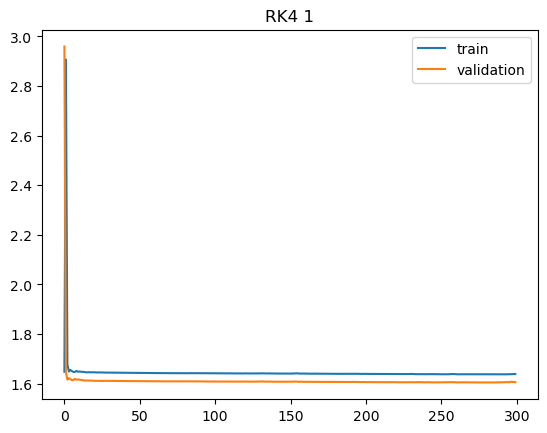

In [13]:
ode1 = ODE1().to(DEVICE)
rk4_1 = RK4(ode1).to(DEVICE)
rk4_1.load_state_dict(torch.load("rk4_1.ckpt"))
optimizer = optim.Adam(rk4_1.parameters(), lr=0.1)
criterion = nn.MSELoss()
train_losses, validation_losses = train("rk4_1", rk4_1, optimizer, criterion, epochs = 300, print_every=10)
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.title("RK4 1")
plt.legend()